In [0]:
from google.colab import files
uploaded = files.upload()

Saving gdn.py to gdn.py


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import copy
import os, sys
import time
import math
from PIL import Image
from skimage import io, transform
import cv2 as cv
from tqdm import tqdm
import shutil
import imutils

from gdn import GDN

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data.dataset import Dataset # For custom datasets
import torchvision.utils as vutils
import torchvision
from torchvision import datasets, transforms,models 

%load_ext autoreload
%autoreload 2

# from google.colab import drive
# drive.mount('/content/drive/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
path = '/content/drive/My Drive/Datasets and Weights/squares_image_colorization'
len(os.listdir(path))

### Create train and validation sets

In [0]:
np.random.seed(456)  #Set seed to maintain the same sampling
valid_files = list(np.random.choice(os.listdir(path), 100))
valid_files_set = set(valid_files)
train_files = []
[train_files.append(file) for file in os.listdir(path) if file not in valid_files_set]
print('Training: {} samples\tValidation: {} samples'.format(len(train_files), len(valid_files)))

Training: 4628 samples	Validation: 100 samples


### Data Loader. It performs data augumentation on images (rotated, horizontally flipped and a little bit distorted) to increase the number of samples observed by the model for the training. It also converts images in B/W. 

In [0]:
class load_data(Dataset):
    def __init__(self, root_dir, files_names, transform=None, transform_gray=None):
        
        self.root_dir = root_dir 
        self.files = files_names
        self.transform = transform
        self.transform_gray = transform_gray

    def __len__(self):
        
        return len(self.files)

    def __getitem__(self, idx):
        
        nameimg = self.files[idx]
        img = io.imread(self.root_dir + '/' + nameimg)        
        sample = {'image': img}

        if self.transform:
            image_t = self.transform(sample["image"])
            if self.transform_gray:
                image_gray = self.transform_gray(image_t)
                sample = {'image': image_t, 'image_gray' : image_gray}
            else:
                sample = {'image': image_t}

        return sample

In [0]:
transf = transforms.Compose([transforms.ToPILImage(),
                             transforms.RandomApply([transforms.RandomCrop(130, pad_if_needed=True)], p=0.4),
                             transforms.RandomHorizontalFlip(p=0.5),
                             transforms.Resize(299),
                             transforms.CenterCrop(299),
                             transforms.ToTensor()])

In [0]:
gray_transf = transforms.Compose([transforms.ToPILImage(),   # Convert to PIL to edit
                                  transforms.Grayscale(num_output_channels=1),
                                  transforms.ToTensor()])

In [0]:
transf_val = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Resize(299),
                                 transforms.CenterCrop(299),
                                 transforms.ToTensor()])

In [0]:
train_loader = torch.utils.data.DataLoader(load_data(path, train_files, 
                                                     transform=transf,
                                                     transform_gray=gray_transf),
                                            batch_size=32)

In [0]:
len(train_loader)

145

In [0]:
valid_loader = torch.utils.data.DataLoader(load_data(path, valid_files, 
                                                     transform=transf_val,
                                                     transform_gray=gray_transf), 
                                           batch_size=16)

In [0]:
len(valid_loader)

7

### Showing some examples

In [0]:
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


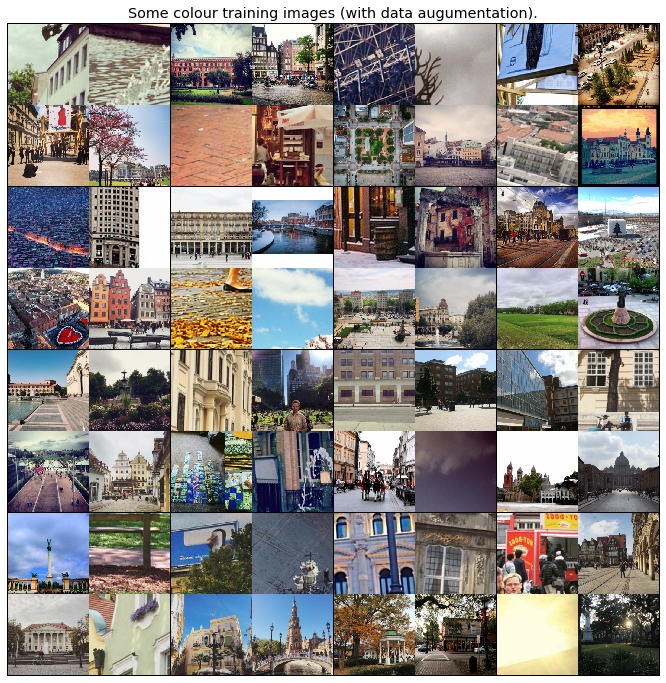

In [0]:
some_train_img = next(iter(train_loader))
plt.figure(figsize=(12,12))
plt.title('Some colour training images (with data augumentation).', fontsize='x-large')
plt.imshow(np.transpose(vutils.make_grid(some_train_img['image'].to(device)[:64], 
                                         padding=2, normalize=True).cpu(), (1,2,0)))
plt.axis('off')
plt.show()

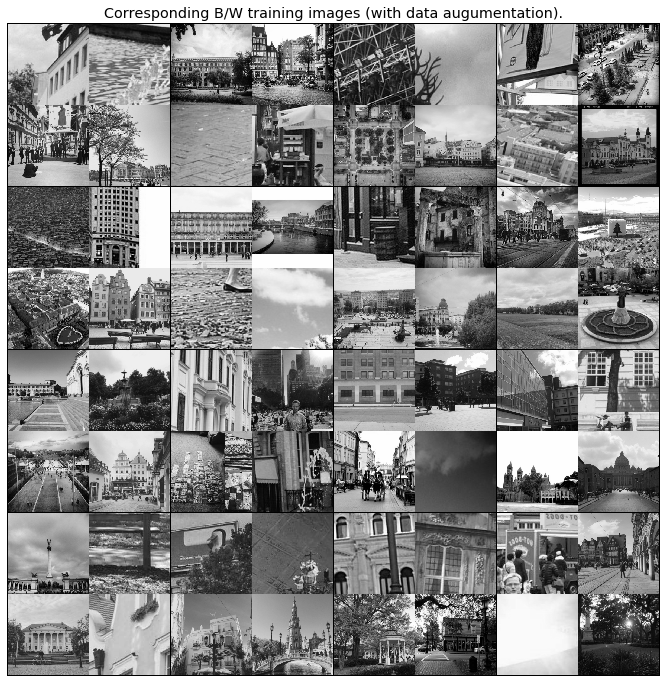

In [0]:
plt.figure(figsize=(12,12))
plt.title('Corresponding B/W training images (with data augumentation).', fontsize='x-large')
plt.imshow(np.transpose(vutils.make_grid(some_train_img['image_gray'].to(device)[:64], 
                                         padding=2, normalize=True).cpu(), (1,2,0)))
plt.axis('off')
plt.show()

In [0]:
some_train_img = None #Free memory

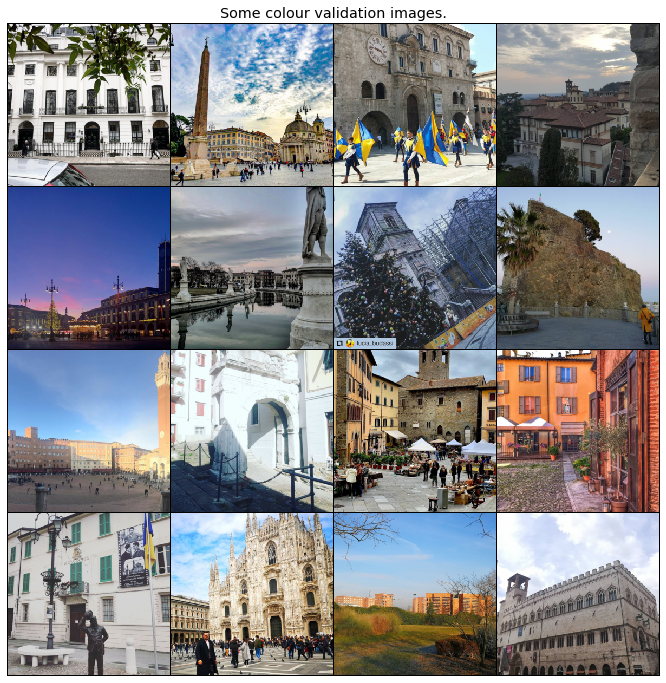

In [0]:
some_val_img = next(iter(valid_loader))
plt.figure(figsize=(12,12))
plt.title('Some colour validation images.', fontsize='x-large')
plt.imshow(np.transpose(vutils.make_grid(some_val_img['image'].to(device)[:16], nrow=4,
                                         padding=2, normalize=True).cpu(), (1,2,0)))
plt.axis('off')
plt.show()

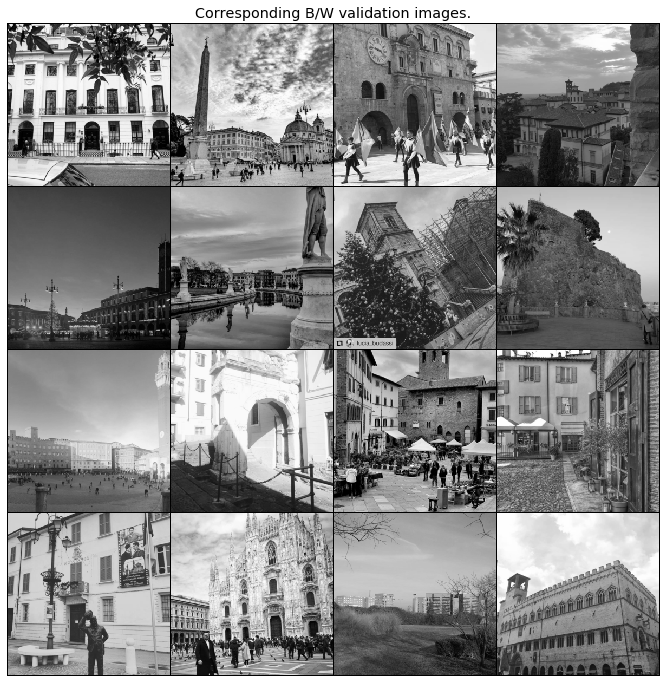

In [0]:
plt.figure(figsize=(12,12))
plt.title('Corresponding B/W validation images.', fontsize='x-large')
plt.imshow(np.transpose(vutils.make_grid(some_val_img['image_gray'].to(device)[:16], nrow=4,
                                         padding=2, normalize=True).cpu(), (1,2,0)))
plt.axis('off')
plt.show()

In [0]:
some_val_img = None

### Define AutoEncoder

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        #Encoding layers
        self.conv1 = nn.Conv2d(1, 32, (5,5), stride=2, padding=1)  #out 16x149x149
        self.conv2 = nn.Conv2d(32, 64, (5,5), stride=2, padding=1) #out 64x74x74
        self.conv3 = nn.Conv2d(64, 128, (4,4), stride=2, padding=0) #out 128x36x36
        self.conv4 = nn.Conv2d(128, 512, (4,4), stride=2, padding=1) #out 512x18x18
        self.conv5 = nn.Conv2d(512, 1024, (4,4), stride=2, padding=1) #out 1024x9x9
        
        #Decoding layers
        self.deconv1 = nn.ConvTranspose2d(1024, 512, (4,4), stride=2, padding=1) #512x18x18
        self.deconv2 = nn.ConvTranspose2d(512, 128, (4,4), stride=2, padding=1)  #128x36x36
        self.deconv3 = nn.ConvTranspose2d(128, 64, (4,4), stride=2, padding=0)   #64x74x74
        self.deconv4 = nn.ConvTranspose2d(64, 32, (5,5), stride=2, padding=1)    #32x149x149
        self.deconv5 = nn.ConvTranspose2d(32, 3, (5,5), stride=2, padding=1)     #3x299x299
        
        #GDN linear activation
        self.gdn1 = GDN(32)
        self.gdn2 = GDN(64)
        self.gdn3 = GDN(128)
        self.gdn4 = GDN(512)
        self.gdn5 = GDN(1024)
        self.gdn_1 = GDN(512, inverse=True)
        self.gdn_2 = GDN(128, inverse=True)
        self.gdn_3 = GDN(64, inverse=True)
        self.gdn_4 = GDN(32, inverse=True)
        
    def Encoder(self, x):
        x = self.gdn1(self.conv1(x))
        x = self.gdn2(self.conv2(x))
        x = self.gdn3(self.conv3(x))
        x = self.gdn4(self.conv4(x))
        z = self.gdn5(self.conv5(x))
        return z
    
    def Decoder(self, z):
        x = self.gdn_1(self.deconv1(z))
        x = self.gdn_2(self.deconv2(x))
        x = self.gdn_3(self.deconv3(x))
        x = self.gdn_4(self.deconv4(x))
        out = F.sigmoid(self.deconv5(x))
        return out

    def forward(self, x):
        z = self.Encoder(x)
        out = self.Decoder(z)
        return out

In [0]:
autoencoder = AutoEncoder()
summary(autoencoder, (1, 299,299), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             832
               GDN-2         [-1, 32, 149, 149]               0
            Conv2d-3           [-1, 64, 74, 74]          51,264
               GDN-4           [-1, 64, 74, 74]               0
            Conv2d-5          [-1, 128, 36, 36]         131,200
               GDN-6          [-1, 128, 36, 36]               0
            Conv2d-7          [-1, 512, 18, 18]       1,049,088
               GDN-8          [-1, 512, 18, 18]               0
            Conv2d-9           [-1, 1024, 9, 9]       8,389,632
              GDN-10           [-1, 1024, 9, 9]               0
  ConvTranspose2d-11          [-1, 512, 18, 18]       8,389,120
              GDN-12          [-1, 512, 18, 18]               0
  ConvTranspose2d-13          [-1, 128, 36, 36]       1,048,704
              GDN-14          [-1, 128,

### Training Loop

In [0]:
def train_model(model, num_epochs=5, scheduler=None):
    since = time.time()

    model = model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10e20
    
    LOGGER_TRAIN_LOSS = {}
    LOGGER_VALID_LOSS = {}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 40)

        # Each epoch has a training and a validation phase so..
        for phase in ['training', 'validation']:
            if phase == 'training':
                if scheduler is not None:
                    scheduler.step()
                    if (epoch+1) % exp_lr_scheduler.step_size == 0:
                        print('Learning Rate Scheduler divides lr by a gamma of {:.1f}.\n'.format(
                              exp_lr_scheduler.gamma))
                        
                model.train()
                lossa = []
                for batch_idx, dizio in enumerate(train_loader):
                    img, img_gray = dizio["image"], dizio["image_gray"]

                    img = img.to(device, dtype=torch.float)
                    img_gray = img_gray.to(device, dtype=torch.float)

                    optimizer.zero_grad()

                    img_colored = model(img_gray)
                    loss = criterion(img_colored, img)
                    lossa.append(loss.mean().item())               
                    
                    loss.backward()
                    optimizer.step()

                    if batch_idx % 25 == 0:
                        print('Training Iteration: {:>3} | Loss : {:>4.3f} |'.format(batch_idx, np.mean(lossa)))

                print('Training EP#{} --> | Loss: {:>4.3f} |'.format(epoch+1, np.mean(lossa)))
                LOGGER_TRAIN_LOSS.update({epoch+1:np.mean(lossa)})
                
            else:
                model.eval()
                lossa = []
                for batch_idx, dizio in enumerate(valid_loader):
                    img, img_gray = dizio["image"], dizio["image_gray"]

                    img = img.to(device, dtype=torch.float)
                    img_gray = img_gray.to(device, dtype=torch.float)

                    img_colored = model(img_gray)
                    loss = criterion(img_colored, img)
                    lossa.append(loss.mean().item())
             
                epoch_loss = np.mean(lossa)
                print('Validation EP#{} --> | Loss: {:>4.3f} |'.format(epoch+1, epoch_loss))  
                LOGGER_VALID_LOSS.update({epoch+1:epoch_loss})
                print('-' * 40)
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print()
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}min and {:.0f}sec\nBest validation Loss: {:.3f}'.format(time_elapsed // 60,
                                                                 time_elapsed % 60, best_loss))
    
    #load best model weights and return it
    model.load_state_dict(best_model_wts)
    return model, LOGGER_TRAIN_LOSS, LOGGER_VALID_LOSS

In [0]:
autoencoder = AutoEncoder()
criterion = nn.L1Loss()
optimizer = optim.Adam(autoencoder.parameters(), lr= 5e-4)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, 
                                             gamma= 0.2)

In [16]:
model_trained, trn_lss, val_lss = train_model(autoencoder, num_epochs=35, 
                                              scheduler=exp_lr_scheduler)

Epoch 1/35
----------------------------------------
Training Iteration:   0 | Loss : 0.230 |
Training Iteration:  25 | Loss : 0.246 |
Training Iteration:  50 | Loss : 0.225 |
Training Iteration:  75 | Loss : 0.194 |
Training Iteration: 100 | Loss : 0.176 |
Training Iteration: 125 | Loss : 0.164 |
Training EP#1 --> | Loss: 0.156 |
Validation EP#1 --> | Loss: 0.118 |
----------------------------------------

Epoch 2/35
----------------------------------------
Training Iteration:   0 | Loss : 0.111 |
Training Iteration:  25 | Loss : 0.106 |
Training Iteration:  50 | Loss : 0.102 |
Training Iteration:  75 | Loss : 0.102 |
Training Iteration: 100 | Loss : 0.100 |
Training Iteration: 125 | Loss : 0.099 |
Training EP#2 --> | Loss: 0.098 |
Validation EP#2 --> | Loss: 0.106 |
----------------------------------------

Epoch 3/35
----------------------------------------
Training Iteration:   0 | Loss : 0.098 |
Training Iteration:  25 | Loss : 0.094 |
Training Iteration:  50 | Loss : 0.091 |
Train

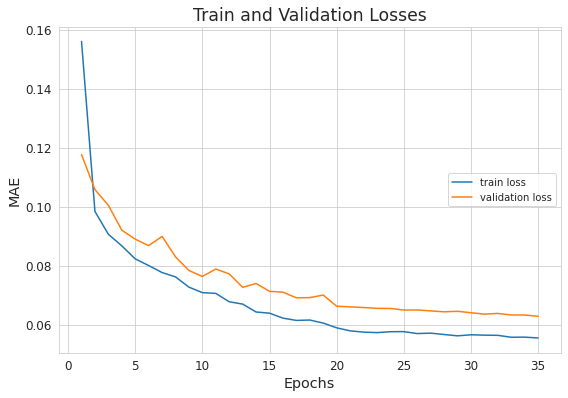

In [17]:
# LOSSES
sns.set_style('whitegrid')
plt.figure(figsize=(9,6))
plt.plot(*zip(*sorted(trn_lss.items())),label='train loss')
plt.plot(*zip(*sorted(val_lss.items())),label='validation loss')
plt.legend(loc='center right')
plt.title('Train and Validation Losses', fontsize='xx-large')
plt.xlabel('Epochs', fontsize='x-large')
plt.ylabel('MAE', fontsize='x-large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')
plt.show()

Try best model in terms of loss on validation

In [0]:
test = next(iter(valid_loader))
test['image_gray'] = test['image_gray'].to(device)
img_test = model_trained(test['image_gray']).detach()

In [19]:
len(img_test)

16

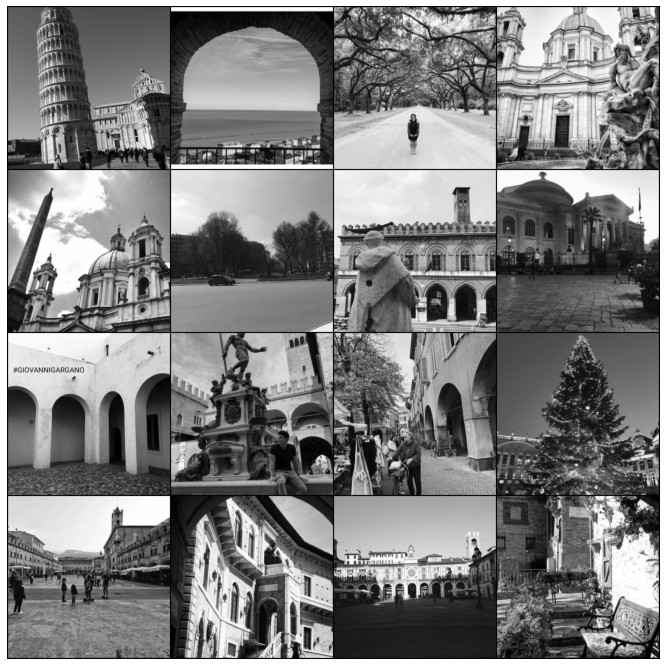

In [20]:
plt.figure(figsize=(12,12))
# plt.title('Some colour validation images.', fontsize='x-large')
plt.imshow(np.transpose(vutils.make_grid(test['image_gray'], nrow=4,
                                         padding=2, normalize=True).cpu(), (1,2,0)))
plt.axis('off')
plt.show()

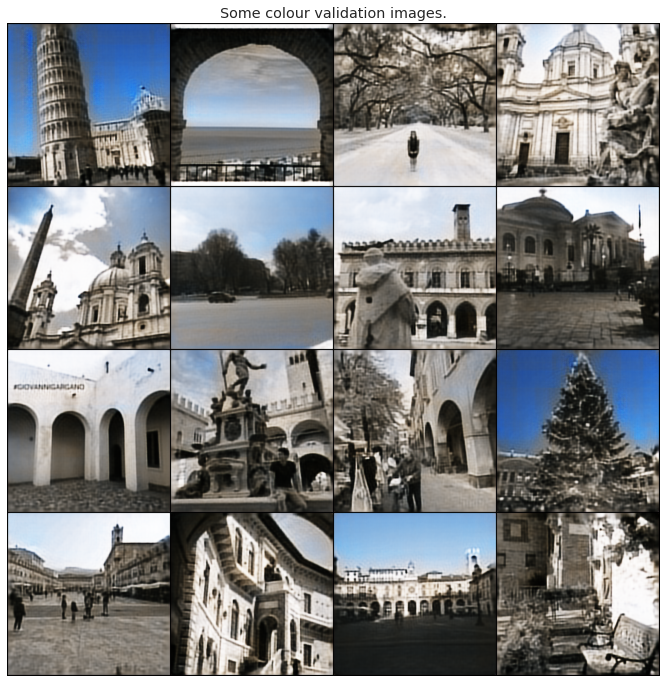

In [21]:
plt.figure(figsize=(12,12))
plt.title('Some colour validation images.', fontsize='x-large')
plt.imshow(np.transpose(vutils.make_grid(img_test, nrow=4,
                                         padding=2, normalize=True).cpu(), (1,2,0)))
plt.axis('off')
plt.show()

In [0]:
z_img_test = model_trained.Encoder(test['image_gray']).detach()

In [23]:
z_img_test[0][0]

tensor([[-0.0084, -0.0421,  0.1009,  0.0854,  0.0765,  0.0579,  0.0601,  0.0630,
          0.1031],
        [-0.1031,  0.2257,  0.0955, -0.0212,  0.0496, -0.0017, -0.0109, -0.0036,
          0.0255],
        [-0.1598,  0.1960,  0.2777, -0.4002,  0.0919, -0.0018, -0.0014, -0.0371,
         -0.0181],
        [-0.1551,  0.1225,  0.3210, -0.0460,  0.1412, -0.0065,  0.0675,  0.2309,
         -0.0038],
        [-0.1472,  0.2818, -0.0732, -0.3344, -0.0014, -0.0234,  0.0350,  0.0825,
          0.2352],
        [-0.1440,  0.0848,  0.2576, -0.3320,  0.1343,  0.0884, -0.0545, -0.0812,
          0.2837],
        [-0.0243,  0.0526,  0.4173, -0.1724,  0.0535,  0.0582,  0.4750,  0.2271,
          0.0308],
        [-0.3154, -0.0527,  0.6002, -0.0932,  0.1137,  0.1661,  0.3457, -0.0595,
         -0.1657],
        [ 0.2887,  0.2419, -0.0362,  0.3084,  0.2102, -0.1175, -0.2033, -0.0494,
          0.0103]], device='cuda:0')

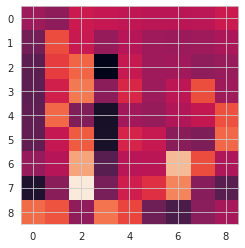

In [24]:
plt.imshow(z_img_test[0][0].cpu().numpy())

### Save weights

In [0]:
torch.save(model_trained.state_dict(), 'AE299x299_weights.pth')

### Continue learning with learning rate scheduler

In [0]:
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=9,
                                             gamma= 0.5)

In [27]:
model_trained, trn_lss, val_lss = train_model(model_trained, num_epochs=20, 
                                             scheduler=exp_lr_scheduler)

Epoch 1/20
----------------------------------------
Training Iteration:   0 | Loss : 0.056 |
Training Iteration:  25 | Loss : 0.054 |
Training Iteration:  50 | Loss : 0.054 |
Training Iteration:  75 | Loss : 0.055 |
Training Iteration: 100 | Loss : 0.055 |
Training Iteration: 125 | Loss : 0.055 |
Training EP#1 --> | Loss: 0.055 |
Validation EP#1 --> | Loss: 0.064 |
----------------------------------------

Epoch 2/20
----------------------------------------
Training Iteration:   0 | Loss : 0.049 |
Training Iteration:  25 | Loss : 0.055 |
Training Iteration:  50 | Loss : 0.055 |
Training Iteration:  75 | Loss : 0.056 |
Training Iteration: 100 | Loss : 0.055 |
Training Iteration: 125 | Loss : 0.056 |
Training EP#2 --> | Loss: 0.055 |
Validation EP#2 --> | Loss: 0.063 |
----------------------------------------

Epoch 3/20
----------------------------------------
Training Iteration:   0 | Loss : 0.056 |
Training Iteration:  25 | Loss : 0.054 |
Training Iteration:  50 | Loss : 0.055 |
Train

In [0]:
test = next(iter(valid_loader))
test['image_gray'] = test['image_gray'].to(device)
img_test = model_trained(test['image_gray']).detach()

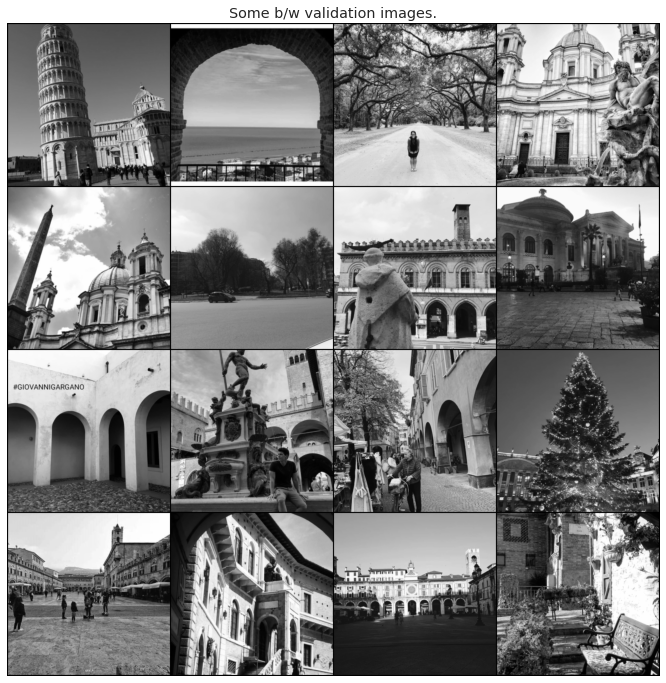

In [31]:
plt.figure(figsize=(12,12))
plt.title('Some b/w validation images.', fontsize='x-large')
plt.imshow(np.transpose(vutils.make_grid(test['image_gray'], nrow=4,
                                         padding=2, normalize=True).cpu(), (1,2,0)))
plt.axis('off')
plt.show()

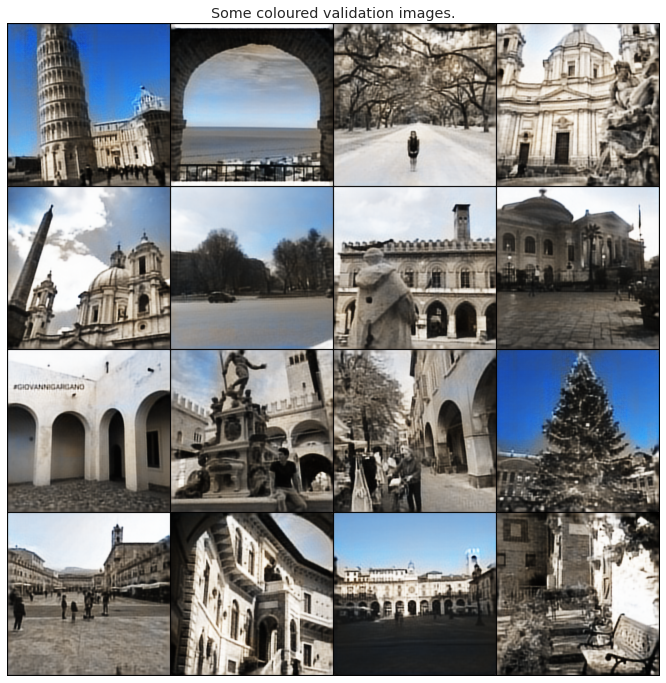

In [32]:
plt.figure(figsize=(12,12))
plt.title('Some coloured validation images.', fontsize='x-large')
plt.imshow(np.transpose(vutils.make_grid(img_test, nrow=4,
                                         padding=2, normalize=True).cpu(), (1,2,0)))
plt.axis('off')
plt.show()

### Save weights

In [0]:
torch.save(model_trained.state_dict(), 'AE299x299_weights_2.pth')